# Build the dataset
From each VH brain, slice from the center with steps of 4-5 and generate about 5 2D images. In total 57x5=285 images (make it adjustable if more images are wanted)

In [1]:
from build_dataset import MRIDatasetBuilder, MRIDataset
from torch.utils.data import DataLoader

In [17]:
#### Example Usage of the MRIDataset
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, CenterCrop, RandomHorizontalFlip, ToTensor, Normalize
from torchvision.transforms.functional import InterpolationMode
data_dir = "/home/benet/data/VH2D/images/flair"
resolution = 256
batch_size = 32
num_workers = 4

preprocess = Compose(
    [
        Resize(resolution, interpolation= InterpolationMode.BILINEAR), #getattr(InterpolationMode, config['processing']['interpolation'])),  # Smaller edge is resized to 256 preserving aspect ratio
        CenterCrop(resolution),  # Center crop to the desired squared resolution
        #RandomHorizontalFlip(),  # Horizontal flip may not be a good idea if we want generation only one laterality
        ToTensor(),  # Convert to PyTorch tensor
        Normalize(mean=[0.5], std=[0.5]),  # Map to (-1, 1) as a way to make data more similar to a Gaussian distribution
        lambda x: x.repeat(3, 1, 1)  # Trick to turn Grayscale into 3 channels
    ]
)

# Create dataset with the defined transformations
dataset = MRIDataset(data_dir, transform=preprocess)
# Create the dataloader
train_dataloader = DataLoader(
    dataset, batch_size=batch_size, num_workers= num_workers, shuffle=True
)
print(f"Number of samples in the dataset: {len(dataset)}")
print(f"Number of batches in the dataloader: {len(train_dataloader)}")


Number of samples in the dataset: 570
Number of batches in the dataloader: 18


In [16]:
# select a sample
dataset.shape

AttributeError: 'MRIDataset' object has no attribute 'shape'

In [12]:
# show one image
import matplotlib.pyplot as plt
import numpy as np
image = dataset[0]
image = image.permute(1, 2, 0)
image = image.numpy()
plt.imshow(image, cmap='gray')
plt.show()


TypeError: img should be Tensor Image. Got <class 'PIL.Image.Image'>

In [25]:
from diffusers import AutoencoderKL
import torch

# Load VAE (You can try both models)
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
vae.eval()


# Get Image
image = dataset[0]  # Single image (1, 256, 256)
image = image.unsqueeze(0)  # Add batch dimension

# Encode into latents
with torch.no_grad():
    latents = vae.encode(image).latent_dist.sample()
    latents = latents * 0.18215  # Scaling used in Stable Diffusion

print("Latents Shape:", latents.shape)  # Expected: (1, 4, 32, 32)


Latents Shape: torch.Size([1, 4, 32, 32])


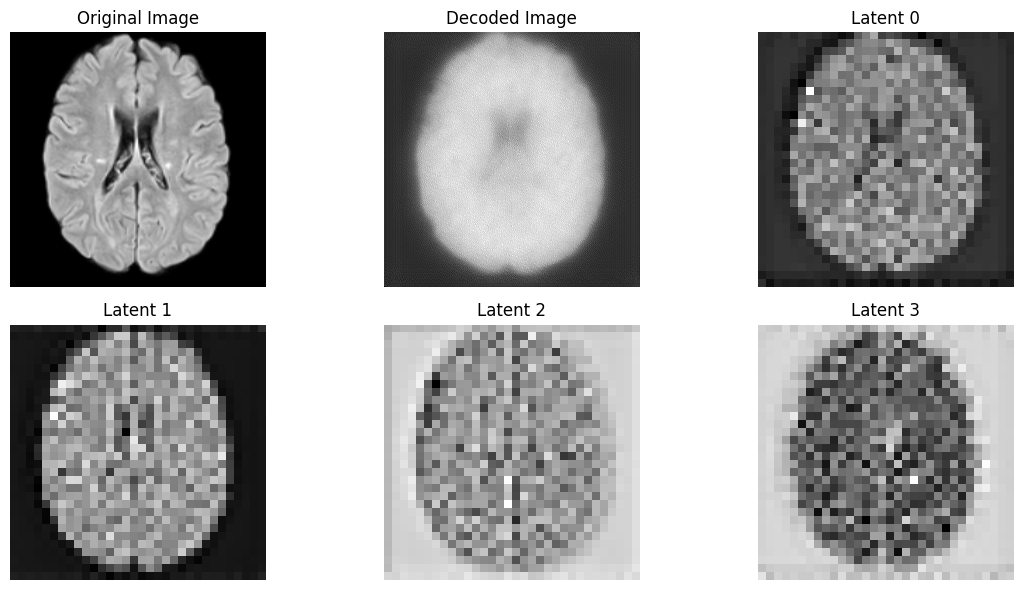

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Decode latents
with torch.no_grad():
    decoded = vae.decode(latents, return_dict=False)[0]

# Plot
plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1)
plt.imshow(image.squeeze(0).cpu().numpy()[0], cmap="gray")  # Original image
plt.title("Original Image")
plt.axis("off")

plt.subplot(2, 3, 2)
plt.imshow(decoded.squeeze(0).cpu().numpy()[0], cmap="gray")  # Decoded image
plt.title("Decoded Image")
plt.axis("off")

for i in range(4):
    plt.subplot(2, 3, i + 3)
    plt.imshow(latents.squeeze(0)[i].cpu().numpy(), cmap="gray")  # Latents
    plt.title(f"Latent {i}")
    plt.axis("off")

plt.tight_layout()
plt.show()
